In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer
from sklearn.cluster import Birch, SpectralClustering, DBSCAN
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score

from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as pe
import seaborn as sns
import matplotlib.pyplot as plt

import umap

In [2]:
data = (
    pd.read_feather('ESP.feather')
    .assign(authors=lambda df_x: df_x.authors.str.replace('<#>', ';'))[['authors', 'title', 'pub_date', 'abstract', 'cite_count', 'doi', 'pii', 'openaccess']]
)
data = data[~data.abstract.str.fullmatch('-1')].reset_index(drop=True)
data

,authors,title,pub_date,abstract,cite_count,doi,pii,openaccess
0,"Zhang, Fengxiu;Xiang, Tianyi",Attending to the unattended: Why and how do lo...,2024-12-31,Research and practice in climate risk reductio...,0,10.1016/j.envsci.2024.103892,S1462901124002260,false
1,"Yoshida, Yuki;Sitas, Nadia;Mannetti, Lelani;O’...",Beyond Academia: A case for reviews of gray li...,2024-12-31,Gray literature is increasingly considered to ...,0,10.1016/j.envsci.2024.103882,S1462901124002168,true
2,"Pietrzyk-Kaszyńska, Agata;Olszańska, Agnieszka",Of heroes and villains – How coalitions shape ...,2024-12-31,Policy narrative analyses provide important in...,0,10.1016/j.envsci.2024.103899,S1462901124002338,false
3,"Zurba, Melanie;Suchet-Pearson, Sandie;Bullock,...",Enhancing meaningful Indigenous leadership and...,2024-12-31,This is the first global empirical study that ...,0,10.1016/j.envsci.2024.103864,S1462901124001989,true
4,"Lemke, Leonard Kwhang-Gil;Beier, Julia;Hanger-...",Exploring procedural justice in stakeholder id...,2024-12-31,"In the face of complex societal challenges, st...",0,10.1016/j.envsci.2024.103900,S146290112400234X,true
...,...,...,...,...,...,...,...,...
3025,"Danila, Donald J",Estimating the abundance and egg production of...,2000-09-01,The winter flounder is a coastal flatfish with...,9,10.1016/S1462-9011(00)00059-9,S1462901100000599,false
3026,"Lorda, Ernesto;Danila, Donald J.;Miller, John D.",Application of a population dynamics model to ...,2000-09-01,A major concern of the Connecticut Department ...,7,10.1016/S1462-9011(00)00061-7,S1462901100000617,false
3027,"Jager, Henriëtte I;Lepla, Ken;Chandler, James;...",Population viability analysis of white sturgeo...,2000-09-01,Many utilities face conflicts between two goal...,13,10.1016/S1462-9011(00)00063-0,S1462901100000630,false
3028,"Farber, Stephen",Welfare-based ecosystem management: an investi...,2000-09-01,This paper investigates the use of welfare-bas...,1,10.1016/S1462-9011(00)00066-6,S1462901100000666,false


In [3]:
class Preprocessing:
    def __init__(self, X):
        '''
        text - pandas series
        '''
        self.sw = stopwords.words('english')
        self.wnl = WordNetLemmatizer()
        self.ps = PorterStemmer()
        self.X = X

    def _remove_special_chars(self, text):
        return re.sub('[^A-Za-z0-9 ]+', '', text)
    
    def remove_special_chars(self):
        self.X = self.X.apply(self._remove_special_chars)
        return self

    def lower_case(self):
        self.X =  self.X.str.lower()
        return self

    def tokenize(self):
        self.X = self.X.apply(wordpunct_tokenize)
        return self
    
    def remove_stopwords(self):
        self.X = self.X.apply(lambda x: [token for token in x if token not in self.sw])
        return self
    
    def stemmer(self):
        self.X = self.X.apply(lambda x: [self.ps.stem(token) for token in x])
        return self
    
    def lemmatize(self):
        self.X = self.X.apply(lambda x: [self.wnl.lemmatize(token) for token in x])
        return self
    
    def get_text(self):
        return self.X

In [4]:
model = SentenceTransformer('all-MiniLM-L12-v2') 

In [55]:
pp = Preprocessing(data.abstract)
pp.remove_special_chars().lower_case().tokenize().remove_stopwords().lemmatize().get_text()

0       [research, practice, climate, risk, reduction,...
1       [gray, literature, increasingly, considered, c...
2       [policy, narrative, analysis, provide, importa...
3       [first, global, empirical, study, specifically...
4       [face, complex, societal, challenge, stakehold...
                              ...                        
3025    [winter, flounder, coastal, flatfish, spawning...
3026    [major, concern, connecticut, department, envi...
3027    [many, utility, face, conflict, two, goal, gen...
3028    [paper, investigates, use, welfarebased, trade...
3029    [wisconsin, electric, power, company, recogniz...
Name: abstract, Length: 3030, dtype: object

In [ ]:
# 2 mins

corpus_embeddings = model.encode(pp.X.apply(lambda x: ' '.join(x)))
np.save('corpus_embeddings', corpus_embeddings)

In [83]:
data[['abstract', 'pub_date']]

,abstract,pub_date
0,Research and practice in climate risk reductio...,2024-12-31
1,Gray literature is increasingly considered to ...,2024-12-31
2,Policy narrative analyses provide important in...,2024-12-31
3,This is the first global empirical study that ...,2024-12-31
4,"In the face of complex societal challenges, st...",2024-12-31
...,...,...
3025,The winter flounder is a coastal flatfish with...,2000-09-01
3026,A major concern of the Connecticut Department ...,2000-09-01
3027,Many utilities face conflicts between two goal...,2000-09-01
3028,This paper investigates the use of welfare-bas...,2000-09-01


In [82]:
pd.DataFrame(corpus_embeddings)

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.110548,0.007706,-0.061401,0.052673,0.086331,0.070158,0.000344,0.037999,-0.036692,0.011655,...,0.053268,-0.022802,0.073479,0.003067,-0.035397,0.012623,-0.005173,-0.005504,-0.053460,0.048226
1,0.065996,0.066021,-0.008647,0.076451,0.014664,0.057418,-0.057534,0.022407,-0.026240,0.059444,...,0.039020,0.089239,0.005222,-0.047291,-0.031283,-0.051189,0.029222,-0.071070,0.044940,0.006325
2,0.049508,0.116063,-0.003712,0.062117,0.121245,0.042588,-0.041203,0.019516,0.041728,0.097406,...,0.067148,0.000568,0.051298,0.058287,0.028754,-0.049078,-0.021667,0.030096,-0.008888,-0.001530
3,0.050021,-0.000770,0.010225,0.047834,0.057153,0.014961,-0.062619,-0.007541,-0.012446,0.057593,...,0.047914,0.001098,-0.036887,-0.044999,0.010190,-0.001400,0.023265,-0.065296,0.042682,0.026167
4,0.068297,0.074023,0.005884,0.019898,0.090572,-0.003090,-0.011513,0.016520,0.024744,0.032146,...,0.075497,0.003692,0.017797,-0.024218,-0.042898,-0.080331,0.000867,0.002219,0.089854,0.008107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3025,0.084562,0.018940,0.044342,-0.013840,0.020322,-0.092348,-0.112491,-0.017853,-0.109252,-0.026387,...,-0.010380,0.044410,0.064201,-0.009240,0.003021,-0.052426,-0.012519,0.030070,-0.013892,0.053830
3026,0.037057,0.038561,0.029419,0.012207,0.083145,-0.087458,-0.059427,-0.037445,-0.120573,0.006625,...,0.020813,0.027654,0.016206,-0.053033,0.062151,-0.089024,-0.056137,0.005253,-0.041017,0.091613
3027,0.031044,0.085039,0.017689,0.010228,-0.001350,-0.107491,-0.044033,0.011036,-0.093352,0.004365,...,0.040174,0.042456,-0.003537,-0.059688,0.021354,-0.038395,-0.035467,-0.014111,0.018926,0.070348
3028,0.090022,0.043672,0.014706,0.056934,0.055326,-0.014266,0.038870,0.028550,-0.081741,-0.000823,...,0.074960,-0.072116,0.009984,-0.027530,0.057741,-0.101165,-0.010624,-0.033362,-0.062341,0.020902


In [ ]:
# MeanShift() removed due to low performance
algs = [SpectralClustering(), Birch()]

sil_score = dict()
clustering = dict()
performances = dict(model=[], labels=[], sil_score=[])
for alg in algs:
    clstr = alg.fit(corpus_embeddings)
    performances['model'].append(alg.__repr__())
    performances['labels'].append(clstr.labels_)
    performances['sil_score'].append(silhouette_score(corpus_embeddings, clstr.labels_))

In [ ]:
perf = pd.DataFrame(performances)
perf[['model', 'sil_score']]

,model,sil_score
0,SpectralClustering(),0.039274
1,Birch(),0.025511


In [ ]:
tsne = TSNE(n_components=3)
X = tsne.fit_transform(corpus_embeddings)

fig = pe.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], color=perf.iloc[1]['labels'], color_continuous_scale='turbid')
fig.update_traces(marker={'size':5})

In [19]:
cembs = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(corpus_embeddings)

In [28]:
algs = [SpectralClustering(), Birch(), DBSCAN()]

performances = dict(model=[], labels=[], sil_score=[])
for alg in algs:
    clstr = alg.fit(cembs)
    performances['model'].append(alg.__repr__())
    performances['labels'].append(clstr.labels_)
    performances['sil_score'].append(silhouette_score(cembs, clstr.labels_))

In [ ]:
perfs = pd.DataFrame(performances)
perfs[['model', 'sil_score']]

,model,sil_score
0,SpectralClustering(),0.292648
1,Birch(),0.292352
2,DBSCAN(),0.227754


In [30]:
data = data.assign(cluster=perf.iloc[0]['labels'])

In [31]:
def get_topics(df):
    topics = dict()
    for clstr in df.cluster.unique():
        pp = Preprocessing(data.query(f'cluster=={clstr}').abstract)
        pp.remove_special_chars().lower_case().tokenize().remove_stopwords().lemmatize().get_text()

        vectorizer = TfidfVectorizer(max_features=5)
        X = vectorizer.fit_transform(pp.X.apply(lambda x: ' '.join(x)))
        
        topics[clstr] = vectorizer.get_feature_names_out()
    return topics

In [32]:
topics = get_topics(data)
tps = []
for k, v in topics.items():
    tps.append('_'.join(v[:3]))
tps

['adaptation_change_climate',
 'environmental_knowledge_policy',
 'coastal_impact_management',
 'change_environmental_food',
 'air_emission_environmental',
 'conservation_forest_land',
 'environmental_flood_policy',
 'management_policy_resource']

In [38]:
toplot = pd.DataFrame({'x': cembs[:, 0], 'y':cembs[:, 1], 'labels': perf.iloc[0]['labels']})
toplot = toplot.assign(topic = toplot.labels.apply(lambda x: tps[x]))
toplot

,x,y,labels,topic
0,12.101449,5.283313,5,conservation_forest_land
1,6.912329,6.688779,0,adaptation_change_climate
2,10.756255,6.155379,0,adaptation_change_climate
3,7.512534,6.130238,0,adaptation_change_climate
4,9.651367,4.408836,0,adaptation_change_climate
...,...,...,...,...
3025,3.444614,2.484843,2,coastal_impact_management
3026,3.546389,2.321198,2,coastal_impact_management
3027,3.346152,2.426905,2,coastal_impact_management
3028,5.450453,1.917054,7,management_policy_resource


In [50]:
pe.scatter(toplot, x='x', y='y', color='topic', width=1000, height=1000)

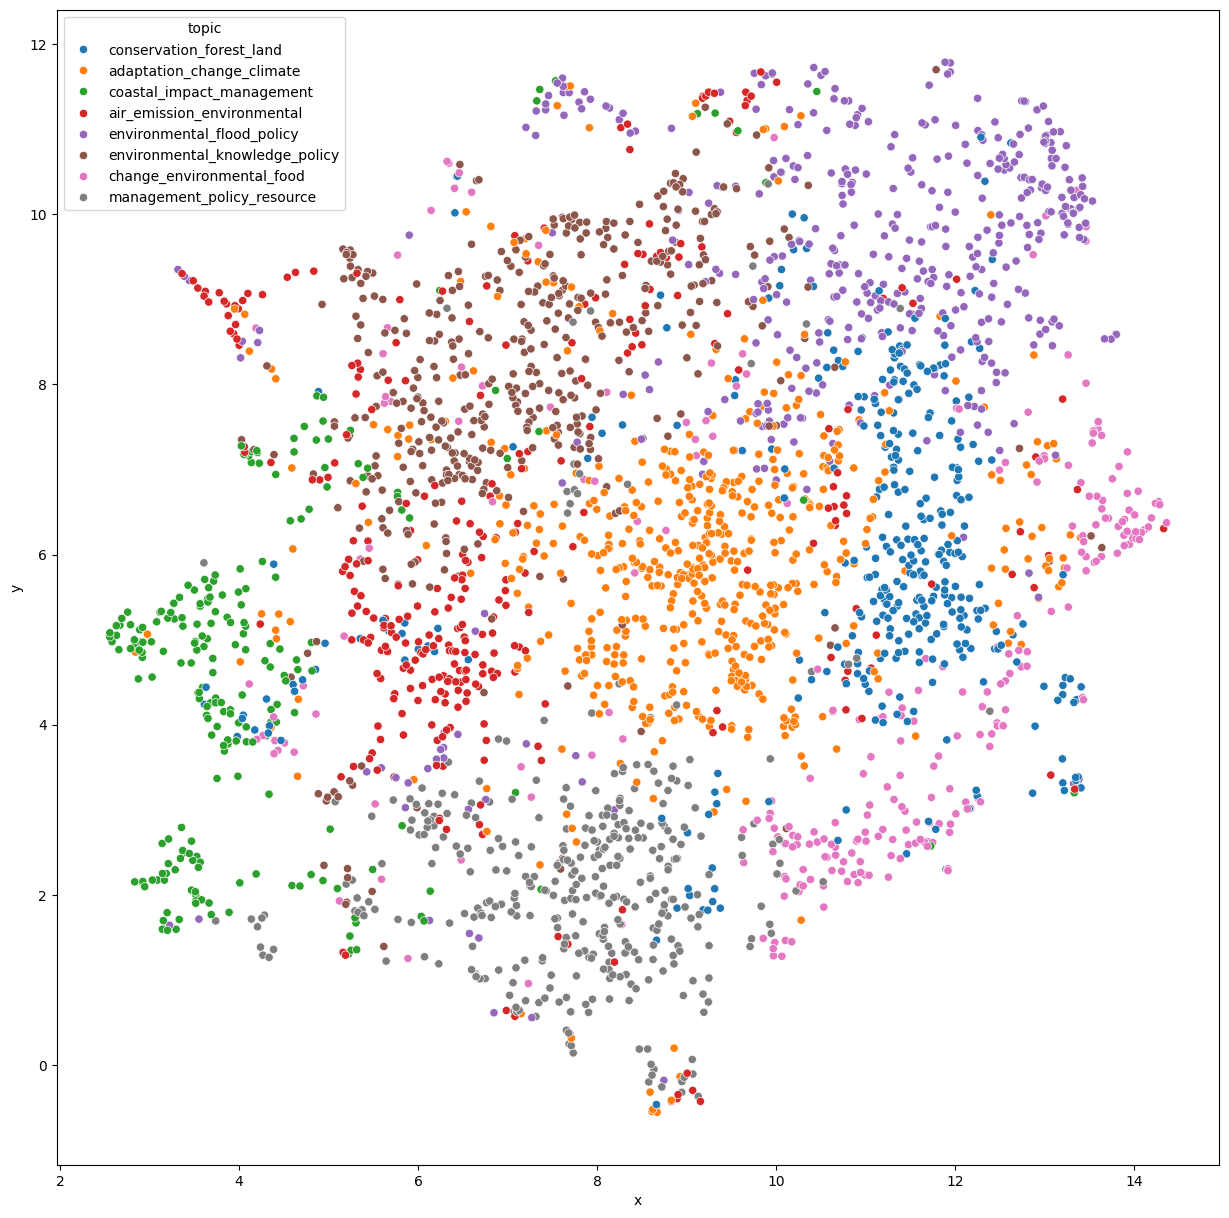

In [46]:
plt.figure(figsize=(15, 15))
g = sns.scatterplot(toplot, x='x', y='y', hue='topic')